# Spotify Data Analysis (R)

## 1. Setup & Data Loading

Loading necessary libraries and the dataset.

In [13]:
if (!require("tidyverse")) install.packages("tidyverse")
if (!require("rpart")) install.packages("rpart")
if (!require("rpart.plot")) install.packages("rpart.plot")

library(tidyverse)
library(rpart)
library(rpart.plot)

# Load Data
df <- read_csv("analysis/Popular_Spotify_Songs.csv", show_col_types = FALSE)

# Clean streams column (convert to numeric)
df <- df %>%
  mutate(streams = as.numeric(as.character(streams))) %>%
  filter(!is.na(streams))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `streams = as.numeric(as.character(streams))`.
Caused by warning:
! NAs introduced by coercion”


## 2. Data Wrangling: Qualitative vs. Quantitative

Splitting the dataset into two sets as requested:
1. **Quantitative Set**: `released_year`, `bpm`, `key`, `mode`, `streams`.
2. **Qualitative Set**: Danceability, Valence, Energy, etc., plus a calculated `qual_factor` (average of qualities).

In [14]:
# MAIN DATA SET i.e. extracting main features from the dataset
quantative_set <- df |> 
  select(released_year, bpm, key, mode, streams)

qualitative_set <- df |> 
  select(streams, `danceability_%`, `valence_%`, `energy_%`, `acousticness_%`, `instrumentalness_%`, `liveness_%`, `speechiness_%`) |> 
  mutate(qual_factor = (`danceability_%` + `valence_%` + `energy_%` + `acousticness_%` + `instrumentalness_%` + `liveness_%` + `speechiness_%`) / 7) |> 
  mutate(stream_adjusted = streams / 1000000)

glimpse(quantative_set)
glimpse(qualitative_set)

Rows: 952
Columns: 5
$ released_year <dbl> 2023, 2023, 2023, 2019, 2023, 2023, 2023, 2023, 2023, 20…
$ bpm           <dbl> 125, 92, 138, 170, 144, 141, 148, 100, 130, 170, 83, 150…
$ key           <chr> "B", "C#", "F", "A", "A", "C#", "F", "F", "C#", "D", "F#…
$ mode          <chr> "Major", "Major", "Major", "Major", "Minor", "Major", "M…
$ streams       <dbl> 141381703, 133716286, 140003974, 800840817, 303236322, 1…
Rows: 952
Columns: 10
$ streams              <dbl> 141381703, 133716286, 140003974, 800840817, 30323…
$ `danceability_%`     <dbl> 80, 71, 51, 55, 65, 92, 67, 67, 85, 81, 57, 78, 7…
$ `valence_%`          <dbl> 89, 61, 32, 58, 23, 66, 83, 26, 22, 56, 56, 52, 6…
$ `energy_%`           <dbl> 83, 74, 53, 72, 80, 58, 76, 71, 62, 48, 72, 82, 6…
$ `acousticness_%`     <dbl> 31, 7, 17, 11, 14, 19, 48, 37, 12, 21, 23, 18, 6,…
$ `instrumentalness_%` <dbl> 0, 0, 0, 0, 63, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17,…
$ `liveness_%`         <dbl> 8, 10, 31, 11, 11, 8, 8, 11, 28, 8, 27, 15, 3, 9

## 3. Stream Classification

Defining popularity classes based on stream thresholds:
*   **Low**: < 150 Million
*   **Medium**: 150M - 675M
*   **High**: > 675 Million

In [15]:
adjusted_quantative_set <- quantative_set |> 
  mutate(stream_class = case_when(
      streams < 150000000 ~ "Low",
      streams >= 150000000 & streams < 675000000 ~ "Medium",
      streams >= 675000000 ~ "High"
  ))

## 4. Model 1: Classification Tree (Using qual_factor)

Attempting to predict popularity using the aggregated `qual_factor`, `bpm`, `key`, and `mode`.

[1] "Confusion Matrix (Model 1):"
         Actual
Predicted High Low Medium
   High     12   4      9
   Low       7  12     21
   Medium   41  62     90
[1] "Model 1 Accuracy: 44.19 %"


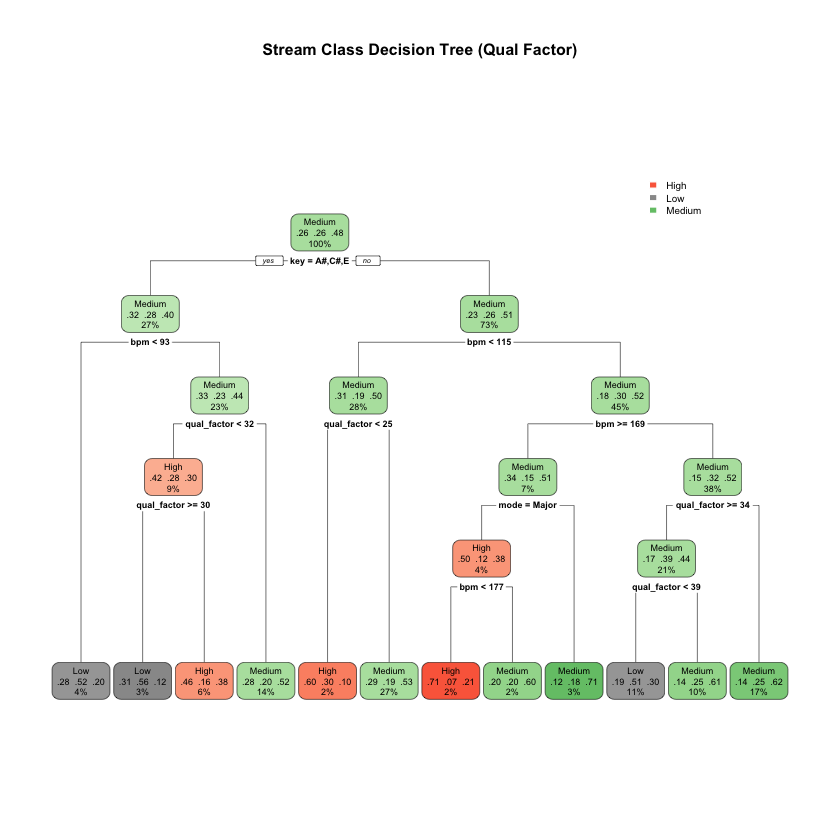

In [16]:
# Combine into Model Data
model_data <- data.frame(
  stream_class = as.factor(adjusted_quantative_set$stream_class),
  bpm = adjusted_quantative_set$bpm,
  key = as.factor(adjusted_quantative_set$key),
  mode = as.factor(adjusted_quantative_set$mode),
  qual_factor = qualitative_set$qual_factor
)

# Remove NAs
model_data <- na.omit(model_data)

# Split Data
set.seed(123)
sample_index <- sample(1:nrow(model_data), 0.7 * nrow(model_data))
train_data <- model_data[sample_index, ]
test_data <- model_data[-sample_index, ]

# Train Model
tree_model <- rpart(stream_class ~ ., data = train_data, method = "class")

# Visualize
rpart.plot(tree_model, main = "Stream Class Decision Tree (Qual Factor)", extra = 104)

# Evaluate
predictions <- predict(tree_model, test_data, type = "class")
conf_matrix <- table(Predicted = predictions, Actual = test_data$stream_class)
print("Confusion Matrix (Model 1):")
print(conf_matrix)

accuracy <- sum(diag(conf_matrix)) / sum(conf_matrix)
print(paste("Model 1 Accuracy:", round(accuracy * 100, 2), "%"))

## 5. Model 2: Improved Classification Tree (All Features)

Improving the model by using all individual features (`danceability_%`, `energy_%`, etc.) instead of the average `qual_factor`, plus `artist_count` and `released_year`.

[1] "Confusion Matrix (Model 2):"
         Actual
Predicted High Low Medium
   High     48   1     27
   Low       0  27     11
   Medium   12  50     82
[1] "Model 2 Accuracy: 60.85 %"


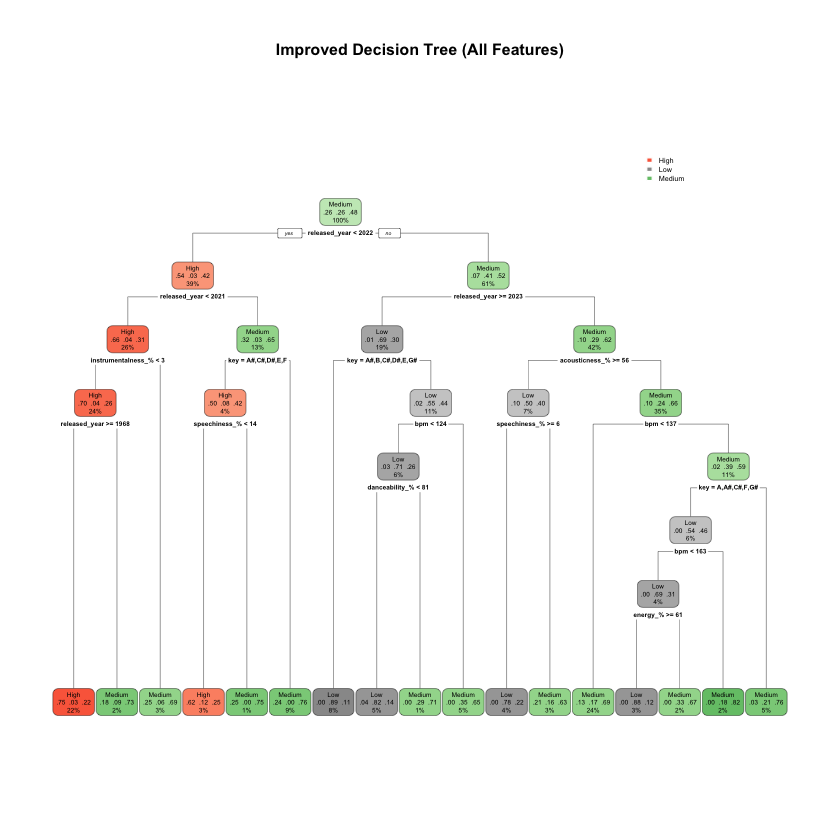

In [17]:
# Prepare Data with ALL features (no averaging)
model_data_improved <- df |>
  select(
    streams, 
    bpm, key, mode,
    `danceability_%`, `valence_%`, `energy_%`, 
    `acousticness_%`, `instrumentalness_%`, `liveness_%`, `speechiness_%`,
    artist_count, released_year
  ) |>
  mutate(stream_class = case_when(
      streams < 150000000 ~ "Low",
      streams >= 150000000 & streams < 675000000 ~ "Medium",
      streams >= 675000000 ~ "High"
  )) |>
  select(-streams) |> # Remove raw streams so the model doesn't cheat
  mutate(
    stream_class = as.factor(stream_class),
    key = as.factor(key),
    mode = as.factor(mode)
  ) |>
  na.omit()

# Split Data
set.seed(123)
sample_index <- sample(1:nrow(model_data_improved), 0.7 * nrow(model_data_improved))
train_data <- model_data_improved[sample_index, ]
test_data <- model_data_improved[-sample_index, ]

# Train Model with lower cp for deeper tree
tree_model_improved <- rpart(stream_class ~ ., data = train_data, method = "class", control = rpart.control(cp = 0.008))

# Visualize
rpart.plot(tree_model_improved, main = "Improved Decision Tree (All Features)", extra = 104)

# Evaluate
predictions <- predict(tree_model_improved, test_data, type = "class")
conf_matrix <- table(Predicted = predictions, Actual = test_data$stream_class)

print("Confusion Matrix (Model 2):")
print(conf_matrix)

accuracy <- sum(diag(conf_matrix)) / sum(conf_matrix)
print(paste("Model 2 Accuracy:", round(accuracy * 100, 2), "%"))